In [1]:
!pip install ipympl torchviz
!pip install torch==1.13 --extra-index-url https://download.pytorch.org/whl/cpu
# restart your runtime after this step

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.3/510.3 KB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 16.4 MB/s eta 0:00:00
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=97790950175e2dbf123f710738711544c8ac81703d2de7671efdd0e22902db6a
  Stored in directory: /root/.cache/pip/wheels/05/7d/1b/8306781244e42ede119edbb053bdcda1c1f424ca226165a417
Successfully built torchviz
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.5/198.5 MB 5.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.13.0+cpu which is incompatible.
torchtext 0.14.1 requires torch==1.13.1, but you have torch 1.13.0+cpu which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you have torch 1.13.0+cpu which is incompatible.


In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import tqdm

import IPython
from ipywidgets import interactive, widgets, Layout
from IPython.display import display, HTML

In [2]:
print(torch.__version__, torch.cuda.is_available())
# Homework 0 does not require a GPU

1.13.0+cpu False


In [3]:
# enable matplotlib widgets;

# on Google Colab
from google.colab import output
output.enable_custom_widget_manager()

%matplotlib widget

In [4]:
# Constants
cap_value = 1e-6          # Farads
R_init = 500              # Ohms
cutoff_mag = 1. / math.sqrt(2)
cutoff_dB = 20 * math.log10(cutoff_mag)
dataset_size = 1000
max_training_steps = 100000

## (a) Designing a Low Pass Filter by Matching Transfer Functions

In [5]:
# Transfer function: evaluates magnitude of given frequencies for a resistor value in the low pass circuit
def evaluate_lp_circuit(freqs, R_low):
    return 1. / torch.sqrt(1 + (R_low * cap_value * freqs) ** 2)

interactive(children=(IntSlider(value=500, description='R', layout=Layout(width='100%'), max=1000, min=1), Out…

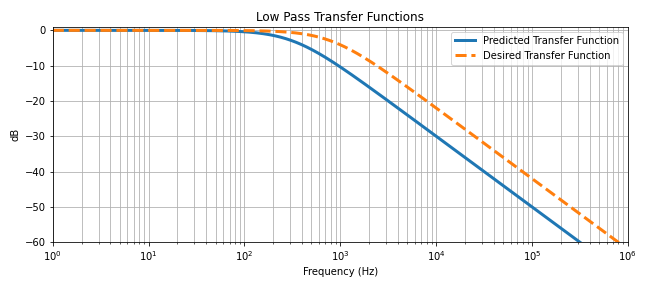

In [6]:
# Plot transfer function for a given low pass circuit
fig = plt.figure(figsize=(9, 4))
ws = 2 * math.pi * 10 ** torch.linspace(0, 6, 1000)
mags = 20 * torch.log10(evaluate_lp_circuit(ws, R_init))
R_low_des = 1 / (2 * math.pi * 800 * cap_value)
mags_des = 20 * torch.log10(evaluate_lp_circuit(ws, R_low_des))
tf, = plt.semilogx(ws / (2 * math.pi), mags, linewidth=3)
tf_des, = plt.semilogx(ws / (2 * math.pi), mags_des, linestyle="--", linewidth=3)
plt.xlim([1, 1e6])
plt.ylim([-60, 1])
plt.title("Low Pass Transfer Functions")
plt.xlabel("Frequency (Hz)")
plt.ylabel("dB")
plt.grid(which="both")
leg = plt.legend(["Predicted Transfer Function", "Desired Transfer Function"])
plt.tight_layout()

# Main update function for interactive plot
def update_tfs(R=R_init):
    mags = 20 * torch.log10(evaluate_lp_circuit(ws, R))
    tf.set_data(ws / (2 * math.pi), mags)
    fig.canvas.draw_idle()
    
# Include sliders for relevant quantities
ip = interactive(update_tfs, 
                 R=widgets.IntSlider(value=R_init, min=1, max=1000, step=1, description="R", layout=Layout(width='100%')))
ip

## (b) Designing a Low pass Filter from Binary Data

interactive(children=(IntSlider(value=500, description='R', layout=Layout(width='100%'), max=1000, min=1), Out…

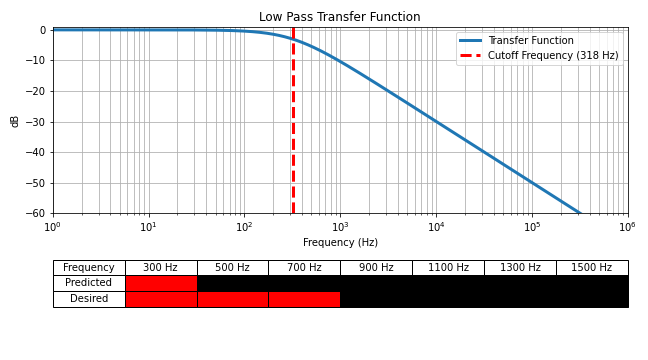

In [7]:
# Plot transfer function for a given low pass circuit
fig = plt.figure(figsize=(9, 5))
ws = 2 * math.pi * 10 ** torch.linspace(0, 6, 1000)
mags = 20 * torch.log10(evaluate_lp_circuit(ws, R_init))
cutoff = ws[np.argmax(mags < cutoff_dB)]
tf, = plt.semilogx(ws / (2 * math.pi), mags, linewidth=3)
cut = plt.axvline(cutoff / (2 * math.pi), c="red", linestyle="--", linewidth=3)
plt.xlim([1, 1e6])
plt.ylim([-60, 1])
plt.title("Low Pass Transfer Function")
plt.xlabel("Frequency (Hz)")
plt.ylabel("dB")
plt.grid(which="both")
leg = plt.legend(["Transfer Function", f"Cutoff Frequency ({1 / (2 * math.pi * R_init * cap_value):.0f} Hz)"])

# Plot table of LED on/off values (predicted and desired)
ws_test = 2 * math.pi * np.linspace(300, 1500, num=7)
table_txt = np.zeros((3, len(ws_test) + 1), dtype="U15")
table_txt[0, :] = ["Frequency"] + [f"{w / (2 * math.pi):.0f} Hz" for w in ws_test]
table_txt[1:, 0] = ["Predicted", "Desired"]
table_colors = np.zeros_like(table_txt, dtype=(np.int32, (3,)))
table_colors[-1, 1:4] = (1, 0, 0)
table_colors[1, 1] = (1, 0, 0)
table_colors[:, :1] = (1, 1, 1)
table_colors[:1, :] = (1, 1, 1)
tab = plt.table(table_txt, table_colors, bbox=[0.0, -0.5, 1.0, 0.25], cellLoc="center")
plt.tight_layout()

# Main update function for interactive plot
def update_lights(R=R_init):
    mags = 20 * torch.log10(evaluate_lp_circuit(ws, R))
    cutoff = ws[np.argmax(mags < cutoff_dB)]
    tf.set_data(ws / (2 * math.pi), mags)
    cut.set_xdata(cutoff / (2 * math.pi))
    for i, w in enumerate(ws_test):
        if w < cutoff:
            tab[(1, i+1)].set_facecolor((1, 0, 0))
        else:
            tab[(1, i+1)].set_facecolor((0, 0, 0))
    leg.get_texts()[1].set_text(f"Cutoff Frequency ({1 / (2 * math.pi * R * cap_value):.0f} Hz)")
    fig.canvas.draw_idle()
    
# Include sliders for relevant quantities
ip = interactive(update_lights, 
                 R=widgets.IntSlider(value=R_init, min=1, max=1000, step=1, description="R", layout=Layout(width='100%')))
ip

## (c) Learning a Low Pass Filter from Desired Transfer Function Samples

In [8]:
# PyTorch model of the low pass circuit (for training)
class LowPassCircuit(nn.Module):
    def __init__(self, R=None):
        super().__init__()
        self.R = nn.Parameter(torch.tensor(R, dtype=float) if R is not None else torch.rand(1) * 1000)
        
    # Note: the forward function is called automatically when the __call__ function of this object is called
    def forward(self, freqs):
        return evaluate_lp_circuit(freqs, self.R)
    
# Generate training data in a uniform log scale of frequences, then evaluate using the true transfer function
def generate_lp_training_data(n):
    rand_ws = 2 * math.pi * torch.pow(10, torch.rand(n) * 6)
    labels = evaluate_lp_circuit(rand_ws, R_low_des)
    return rand_ws, labels

# Train a given low pass filter
def train_lp_circuit_tf(circuit, loss_fn, dataset_size, max_training_steps, lr):
    
    R_values = [float(circuit.R.data)]
    grad_values = [np.nan]
    train_data = generate_lp_training_data(dataset_size)
    print(f"Initial Resistor Value: R = {float(circuit.R.data):.0f}")
    iter_bar = tqdm.trange(max_training_steps, desc="Training Iter")
    for i in iter_bar:
        pred = circuit(train_data[0])
        loss = loss_fn(pred, train_data[1]).mean()
        grad = torch.autograd.grad(loss, circuit.R)
        with torch.no_grad():
            circuit.R -= lr * grad[0]

        R_values.append(float(circuit.R.data))
        grad_values.append(float(grad[0].data))
        iter_bar.set_postfix_str(f"Loss: {float(loss.data):.3f}, R={float(circuit.R.data):.0f}")
        if loss.data < 1e-6 or abs(grad[0].data) < 1e-6:
            break

    print(f"Final Resistor Value: R = {float(circuit.R.data):.0f}")        
    return train_data, R_values, grad_values

In [9]:
# Create a circuit, use mean squared error loss w/ learning rate of 200
circuit = LowPassCircuit(1000)
loss_fn = lambda x, y: (x - y) ** 2
lr = 200
train_data_low_tf, R_values_low_tf, grad_values_low_tf = train_lp_circuit_tf(circuit, loss_fn, dataset_size, max_training_steps, lr)

Initial Resistor Value: R = 1000


Training Iter:  83%|████████▎ | 82689/100000 [04:52<01:01, 283.05it/s, Loss: 0.000, R=200]

Final Resistor Value: R = 200


interactive(children=(IntSlider(value=0, description='Training Iteration', layout=Layout(width='100%'), max=82…

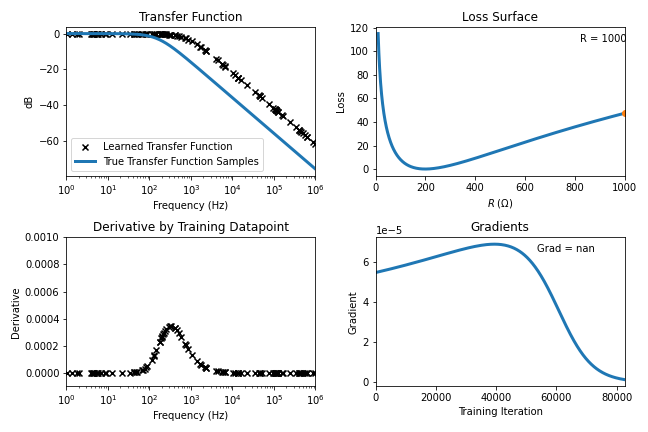

In [10]:
# Plot transfer function over training
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 6))
ws = 2 * math.pi * 10 ** torch.linspace(0, 6, 1000)
subsample = int(dataset_size / 100)
ax1.scatter(train_data_low_tf[0][::subsample] / (2 * math.pi), 20 * torch.log10(train_data_low_tf[1][::subsample]), c="k", marker="x")
learned_tf, = ax1.semilogx(ws / (2 * math.pi), 20 * torch.log10(evaluate_lp_circuit(ws, R_values_low_tf[0])), linewidth=3)
ax1.set_xlim([1, 1e6])
ax1.set_title("Transfer Function")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("dB")
ax1.legend(["Learned Transfer Function", "True Transfer Function Samples"])

# Show loss surface over training
eval_pts = torch.arange(10, 1001, 1)
eval_vals = evaluate_lp_circuit(train_data_low_tf[0][:, None], eval_pts[None, :])
loss_surface_mse = loss_fn(eval_vals, train_data_low_tf[1][:, None].expand(eval_vals.shape))
ax2.plot(eval_pts, loss_surface_mse.sum(0), linewidth=3)
cur_loss, = ax2.plot(R_values_low_tf[0], loss_surface_mse[:, int(R_values_low_tf[0] - 10)].sum(0), marker="o")
cur_loss_label = ax2.annotate(f"R = {R_values_low_tf[0]:.0f}", (0, 0), xytext=(0.82, 0.9), textcoords='axes fraction')
ax2.set_title("Loss Surface")
ax2.set_xlim([0, 1000])
ax2.set_xlabel("$R \; (\Omega)$")
ax2.set_ylabel("Loss")

# Show loss contributions of each data point
cur_circuit = LowPassCircuit(R_values_low_tf[0])
data_losses = loss_fn(cur_circuit(train_data_low_tf[0][::subsample]), (train_data_low_tf[1][::subsample]).float())
data_grads = torch.zeros(len(data_losses))
for i, dl in enumerate(data_losses):
    data_grads[i] = torch.autograd.grad(dl, cur_circuit.R, retain_graph=True)[0]
data_grads_scat = ax3.scatter(train_data_low_tf[0][::subsample] / (2 * math.pi), data_grads, marker="x", c="k")
ax3.set_xscale("log")
ax3.set_ylabel("Derivative")
ax3.set_xlim([1, 1e6])
ax3.set_ylim([-1e-4, 1e-3])
ax3.set_xlabel("Frequency (Hz)")
ax3.set_title("Derivative by Training Datapoint")

# Show total gradient at each training iteration
ax4.plot(np.arange(len(grad_values_low_tf)), grad_values_low_tf, linewidth=3)
cur_iter, = ax4.plot(0, grad_values_low_tf[0], marker="o")
cur_grad_label = ax4.annotate(f"Grad = {grad_values_low_tf[0]:.2e}", (0, 0), xytext=(0.65, 0.9), textcoords='axes fraction')
ax4.set_xlabel("Training Iteration")
ax4.set_ylabel("Gradient")
ax4.set_title("Gradients")
ax4.set_xlim([-1, len(grad_values_low_tf)])

plt.tight_layout()

# Main update function for interactive plots
def update_iter_tf(t=0):
    learned_tf.set_data(ws / (2 * math.pi), 20 * torch.log10(evaluate_lp_circuit(ws, R_values_low_tf[t])))
    cur_loss.set_data(R_values_low_tf[t], loss_surface_mse[:, int(R_values_low_tf[t] - 10)].sum(0))
    cur_loss_label.set_text(f"R = {R_values_low_tf[t]:.0f}")
    cur_iter.set_data(t, grad_values_low_tf[t])
    cur_grad_label.set_text(f"Grad = {grad_values_low_tf[t]:.2e}")
    cur_circuit = LowPassCircuit(R_values_low_tf[t])
    data_losses = loss_fn(cur_circuit(train_data_low_tf[0][::subsample]), (train_data_low_tf[1][::subsample]).float())
    data_grads = torch.zeros(len(data_losses))
    for i, dl in enumerate(data_losses):
        data_grads[i] = torch.autograd.grad(dl, cur_circuit.R, retain_graph=True)[0]
    data_grads_scat.set_offsets(torch.stack((train_data_low_tf[0][::subsample] / (2 * math.pi), data_grads)).T)
    fig.canvas.draw_idle()
    
# Include sliders for relevant quantities
ip = interactive(update_iter_tf, 
                 t=widgets.IntSlider(value=0, min=0, max=len(R_values_low_tf) - 1, step=1, description="Training Iteration", style={'description_width': 'initial'}, layout=Layout(width='100%')))
ip

## (d) Learning a Low Pass Filter from Binary Data with Mean Squared Error Loss

In [11]:
# Train a given low pass filter from binary data
def train_lp_circuit_binary(circuit, loss_fn, dataset_size, max_training_steps, lr):
    
    R_values = [float(circuit.R.data)]
    grad_values = [np.nan]
    train_data = generate_lp_training_data(dataset_size)
    print(f"Initial Resistor Value: R = {float(circuit.R.data):.0f}")
    iter_bar = tqdm.trange(max_training_steps, desc="Training Iter")
    for i in iter_bar:
        pred = circuit(train_data[0])
        ### YOUR CODE HERE
        loss = loss_fn(pred, (train_data[1] > cutoff_mag).float()).mean()
        ### END YOUR CODE
        grad = torch.autograd.grad(loss, circuit.R)
        with torch.no_grad():
            circuit.R -= lr * grad[0]

        R_values.append(float(circuit.R.data))
        grad_values.append(float(grad[0].data))
        iter_bar.set_postfix_str(f"Loss: {float(loss.data):.3f}, R={float(circuit.R.data):.0f}")
        if loss.data < 1e-6 or abs(grad[0].data) < 1e-6:
            break

    print(f"Final Resistor Value: R = {float(circuit.R.data):.0f}")        
    return train_data, R_values, grad_values

In [12]:
# Create a circuit, use MSE loss with learning rate of 200
circuit = LowPassCircuit(500)
loss_fn = lambda x, y: (x - y) ** 2
lr = 200
train_data_low_bin, R_values_low_bin, grad_values_low_bin = train_lp_circuit_binary(circuit, loss_fn, dataset_size, max_training_steps, lr)

Initial Resistor Value: R = 500


Training Iter:  56%|█████▌    | 55962/100000 [03:03<02:24, 304.24it/s, Loss: 0.020, R=346]

Final Resistor Value: R = 346


interactive(children=(IntSlider(value=0, description='Training Iteration', layout=Layout(width='100%'), max=55…

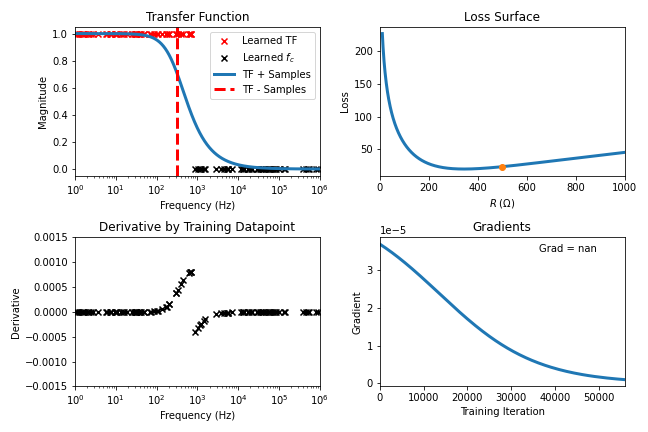

In [13]:
# Plot transfer function over training
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 6))
ws = 2 * math.pi * 10 ** torch.linspace(0, 6, 1000)
subsample = int(dataset_size / 100)
train_data_mask = train_data_low_bin[1][::subsample] > cutoff_mag
ax1.scatter(train_data_low_bin[0][::subsample][train_data_mask] / (2 * math.pi), np.ones(train_data_mask.sum()), c="r", marker="x")
ax1.scatter(train_data_low_bin[0][::subsample][~train_data_mask] / (2 * math.pi), np.zeros((~train_data_mask).sum()), c="k", marker="x")
mags = evaluate_lp_circuit(ws, R_values_low_bin[0])
learned_tf, = ax1.semilogx(ws / (2 * math.pi), mags, linewidth=3)
cutoff = ws[np.argmax(mags < cutoff_mag)]
cut = ax1.axvline(cutoff / (2 * math.pi), c="red", linestyle="--", linewidth=3)
ax1.set_xlim([1, 1e6])
ax1.set_title("Transfer Function")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Magnitude")
ax1.legend(["Learned TF", "Learned $f_c$", "TF + Samples", "TF - Samples"])

# Show loss surface over training
eval_pts = torch.arange(10, 1001, 1)
eval_vals = evaluate_lp_circuit(train_data_low_bin[0][:, None], eval_pts[None, :])
loss_surface_mse = loss_fn(eval_vals, (train_data_low_bin[1][:, None].expand(eval_vals.shape) > cutoff_mag).float())
ax2.plot(eval_pts, loss_surface_mse.sum(0), linewidth=3)
cur_loss, = ax2.plot(R_values_low_bin[0], loss_surface_mse[:, int(R_values_low_bin[0] - 10)].sum(0), marker="o")
cur_loss_label = ax2.annotate(f"R = {R_values_low_bin[0]:.0f}", (0, 0), xytext=(0.82, 0.9), textcoords='axes fraction')
ax2.set_title("Loss Surface")
ax2.set_xlim([0, 1000])
ax2.set_xlabel("$R \; (\Omega)$")
ax2.set_ylabel("Loss")

# Show loss contributions of each data point
cur_circuit = LowPassCircuit(R_values_low_bin[0])
data_losses = loss_fn(cur_circuit(train_data_low_bin[0][::subsample]), (train_data_low_bin[1][::subsample] > cutoff_mag).float())
data_grads = torch.zeros(len(data_losses))
for i, dl in enumerate(data_losses):
    data_grads[i] = torch.autograd.grad(dl, cur_circuit.R, retain_graph=True)[0]
data_grads_scat = ax3.scatter(train_data_low_bin[0][::subsample] / (2 * math.pi), data_grads, marker="x", c="k")
ax3.set_xscale("log")
ax3.set_ylabel("Derivative")
ax3.set_xlim([1, 1e6])
ax3.set_ylim([-1.5e-3, 1.5e-3])
ax3.set_xlabel("Frequency (Hz)")
ax3.set_title("Derivative by Training Datapoint")

# Show gradient at each training iteration
ax4.plot(np.arange(len(grad_values_low_bin)), grad_values_low_bin, linewidth=3)
cur_iter, = ax4.plot(0, grad_values_low_bin[0], marker="o")
cur_grad_label = ax4.annotate(f"Grad = {grad_values_low_bin[0]:.2e}", (0, 0), xytext=(0.65, 0.9), textcoords='axes fraction')
ax4.set_xlabel("Training Iteration")
ax4.set_ylabel("Gradient")
ax4.set_title("Gradients")
ax4.set_xlim([-1, len(grad_values_low_bin)])

plt.tight_layout()

# Main update function for interactive plots
def update_iter_low_bin(t=0):
    mags = evaluate_lp_circuit(ws, R_values_low_bin[t])
    learned_tf.set_data(ws / (2 * math.pi), mags)
    cutoff = ws[np.argmax(mags < cutoff_mag)]
    cut.set_xdata(cutoff / (2 * math.pi))
    cur_loss.set_data(R_values_low_bin[t], loss_surface_mse[:, int(R_values_low_bin[t] - 10)].sum(0))
    cur_loss_label.set_text(f"R = {R_values_low_bin[t]:.0f}")
    cur_iter.set_data(t, grad_values_low_bin[t])
    cur_grad_label.set_text(f"Grad = {grad_values_low_bin[t]:.2e}")
    cur_circuit = LowPassCircuit(R_values_low_bin[t])
    data_losses = loss_fn(cur_circuit(train_data_low_bin[0][::subsample]), (train_data_low_bin[1][::subsample] > cutoff_mag).float())
    data_grads = torch.zeros(len(data_losses))
    for i, dl in enumerate(data_losses):
        data_grads[i] = torch.autograd.grad(dl, cur_circuit.R, retain_graph=True)[0]
    data_grads_scat.set_offsets(torch.stack((train_data_low_bin[0][::subsample] / (2 * math.pi), data_grads)).T)
    fig.canvas.draw_idle()
    
# Include sliders for relevant quantities
ip = interactive(update_iter_low_bin, 
                 t=widgets.IntSlider(value=0, min=0, max=len(R_values_low_bin) - 1, step=1, description="Training Iteration", style={'description_width': 'initial'}, layout=Layout(width='100%')))
ip

## (e) Learning a Low Pass Filter from Binary Data with a Different Loss

In [14]:
circuit = LowPassCircuit(500)
### YOUR CODE HERE
loss_fn = lambda x, y: (x - (0.3 + 0.7 * y)) ** 2
### END YOUR CODE
train_data_low_bin, R_values_low_bin, grad_values_low_bin = train_lp_circuit_binary(circuit, loss_fn, dataset_size, max_training_steps, lr)

Initial Resistor Value: R = 500


Training Iter:  43%|████▎     | 42857/100000 [02:20<03:06, 305.75it/s, Loss: 0.035, R=191]

Final Resistor Value: R = 191


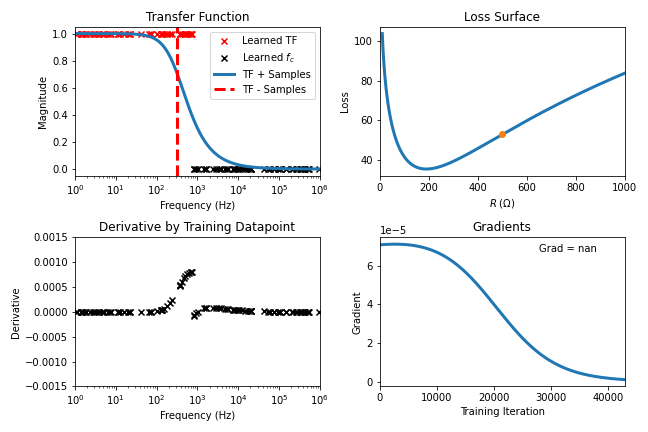

In [15]:
# Plot transfer function over training
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 6))
ws = 2 * math.pi * 10 ** torch.linspace(0, 6, 1000)
subsample = int(dataset_size / 100)
train_data_mask = train_data_low_bin[1][::subsample] > cutoff_mag
ax1.scatter(train_data_low_bin[0][::subsample][train_data_mask] / (2 * math.pi), np.ones(train_data_mask.sum()), c="r", marker="x")
ax1.scatter(train_data_low_bin[0][::subsample][~train_data_mask] / (2 * math.pi), np.zeros((~train_data_mask).sum()), c="k", marker="x")
mags = evaluate_lp_circuit(ws, R_values_low_bin[0])
learned_tf, = ax1.semilogx(ws / (2 * math.pi), mags, linewidth=3)
cutoff = ws[np.argmax(mags < cutoff_mag)]
cut = ax1.axvline(cutoff / (2 * math.pi), c="red", linestyle="--", linewidth=3)
ax1.set_xlim([1, 1e6])
ax1.set_title("Transfer Function")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Magnitude")
ax1.legend(["Learned TF", "Learned $f_c$", "TF + Samples", "TF - Samples"])

# Show loss surface over training
eval_pts = torch.arange(10, 1001, 1)
eval_vals = evaluate_lp_circuit(train_data_low_bin[0][:, None], eval_pts[None, :])
loss_surface_mse = loss_fn(eval_vals, (train_data_low_bin[1][:, None].expand(eval_vals.shape) > cutoff_mag).float())
ax2.plot(eval_pts, loss_surface_mse.sum(0), linewidth=3)
cur_loss, = ax2.plot(R_values_low_bin[0], loss_surface_mse[:, int(R_values_low_bin[0] - 10)].sum(0), marker="o")
cur_loss_label = ax2.annotate(f"R = {R_values_low_bin[0]:.0f}", (0, 0), xytext=(0.82, 0.9), textcoords='axes fraction')
ax2.set_title("Loss Surface")
ax2.set_xlim([0, 1000])
ax2.set_xlabel("$R \; (\Omega)$")
ax2.set_ylabel("Loss")

# Show loss contributions of each data point
cur_circuit = LowPassCircuit(R_values_low_bin[0])
data_losses = loss_fn(cur_circuit(train_data_low_bin[0][::subsample]), (train_data_low_bin[1][::subsample] > cutoff_mag).float())
data_grads = torch.zeros(len(data_losses))
for i, dl in enumerate(data_losses):
    data_grads[i] = torch.autograd.grad(dl, cur_circuit.R, retain_graph=True)[0]
data_grads_scat = ax3.scatter(train_data_low_bin[0][::subsample] / (2 * math.pi), data_grads, marker="x", c="k")
ax3.set_xscale("log")
ax3.set_ylabel("Derivative")
ax3.set_xlim([1, 1e6])
ax3.set_ylim([-1.5e-3, 1.5e-3])
ax3.set_xlabel("Frequency (Hz)")
ax3.set_title("Derivative by Training Datapoint")

# Show gradient at each training iteration
ax4.plot(np.arange(len(grad_values_low_bin)), grad_values_low_bin, linewidth=3)
cur_iter, = ax4.plot(0, grad_values_low_bin[0], marker="o")
cur_grad_label = ax4.annotate(f"Grad = {grad_values_low_bin[0]:.2e}", (0, 0), xytext=(0.65, 0.9), textcoords='axes fraction')
ax4.set_xlabel("Training Iteration")
ax4.set_ylabel("Gradient")
ax4.set_title("Gradients")
ax4.set_xlim([-1, len(grad_values_low_bin)])

plt.tight_layout()

# Main update function for interactive plots
def update_iter_low_bin(t=0):
    mags = evaluate_lp_circuit(ws, R_values_low_bin[t])
    learned_tf.set_data(ws / (2 * math.pi), mags)
    cutoff = ws[np.argmax(mags < cutoff_mag)]
    cut.set_xdata(cutoff / (2 * math.pi))
    cur_loss.set_data(R_values_low_bin[t], loss_surface_mse[:, int(R_values_low_bin[t] - 10)].sum(0))
    cur_loss_label.set_text(f"R = {R_values_low_bin[t]:.0f}")
    cur_iter.set_data(t, grad_values_low_bin[t])
    cur_grad_label.set_text(f"Grad = {grad_values_low_bin[t]:.2e}")
    cur_circuit = LowPassCircuit(R_values_low_bin[t])
    data_losses = loss_fn(cur_circuit(train_data_low_bin[0][::subsample]), (train_data_low_bin[1][::subsample] > cutoff_mag).float())
    data_grads = torch.zeros(len(data_losses))
    for i, dl in enumerate(data_losses):
        data_grads[i] = torch.autograd.grad(dl, cur_circuit.R, retain_graph=True)[0]
    data_grads_scat.set_offsets(torch.stack((train_data_low_bin[0][::subsample] / (2 * math.pi), data_grads)).T)
    fig.canvas.draw_idle()
    
# Include sliders for relevant quantities
ip = interactive(update_iter_low_bin, 
                 t=widgets.IntSlider(value=0, min=0, max=len(R_values_low_bin) - 1, step=1, description="Training Iteration", style={'description_width': 'initial'}, layout=Layout(width='100%')))
ip

## (f) Learning a High Pass Filter from Binary Data

In [16]:
# Transfer function: evaluates magnitude of given frequencies for a resistor value in the high pass circuit
def evaluate_hp_circuit(freqs, R_high):
    ### YOUR CODE HERE
    return (R_high * cap_value * freqs) / torch.sqrt(1 + (R_high * cap_value * freqs) ** 2)
    ### END YOUR CODE

# PyTorch model of the high pass circuit (for training)
class HighPassCircuit(nn.Module):
    def __init__(self, R=None):
        super().__init__()
        self.R = nn.Parameter(torch.tensor(R, dtype=float) if R is not None else torch.rand(1) * 1000)
        
    def forward(self, freqs):
        return evaluate_hp_circuit(freqs, self.R)
    
# Generate training data in a uniform log scale of frequences, then evaluate using the true transfer function
R_high_des = 1 / (2 * math.pi * 5000 * cap_value)
def generate_hp_training_data(n):
    rand_ws = 2 * math.pi * torch.pow(10, torch.rand(n) * 6)
    labels = evaluate_hp_circuit(rand_ws, R_high_des)
    return rand_ws, labels

# Train a given low pass filter from binary data
def train_hp_circuit_binary(circuit, loss_fn, dataset_size, max_training_steps, lr):
    
    R_values = [float(circuit.R.data)]
    grad_values = [np.nan]
    train_data = generate_hp_training_data(dataset_size)
    print(f"Initial Resistor Value: R = {float(circuit.R.data):.0f}")
    iter_bar = tqdm.trange(max_training_steps, desc="Training Iter")
    for i in iter_bar:
        pred = circuit(train_data[0])
        loss = loss_fn(pred, (train_data[1] > cutoff_mag).float()).mean()
        ### YOUR CODE HERE
        grad = torch.autograd.grad(loss, circuit.R)
        ### END YOUR CODE
        with torch.no_grad():
            ### YOUR CODE HERE
            circuit.R -= lr * grad[0]
            ### END YOUR CODE
            
        R_values.append(float(circuit.R.data))
        grad_values.append(float(grad[0].data))
        iter_bar.set_postfix_str(f"Loss: {float(loss.data):.3f}, R={float(circuit.R.data):.0f}")
        if loss.data < 1e-6 or abs(grad[0].data) < 1e-6:
            break

    print(f"Final Resistor Value: R = {float(circuit.R.data):.0f}")        
    return train_data, R_values, grad_values

In [17]:
# Create a circuit, use loss_fn with learning rate of 1000
circuit = HighPassCircuit(500)
### YOUR CODE HERE
lambda x, y: (x - (0.3 + 0.7 * y)) ** 2
### END YOUR CODE
lr = 1000
train_data_high_bin, R_values_high_bin, grad_values_high_bin = train_hp_circuit_binary(circuit, loss_fn, dataset_size, max_training_steps, lr)

Initial Resistor Value: R = 500


Training Iter:   5%|▍         | 4902/100000 [00:17<05:43, 276.88it/s, Loss: 0.047, R=33]

Final Resistor Value: R = 33


interactive(children=(IntSlider(value=0, description='Training Iteration', layout=Layout(width='100%'), max=49…

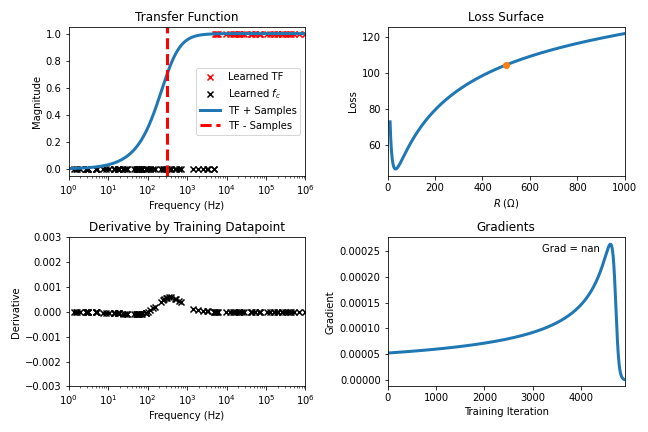

In [18]:
# Plot transfer function over training
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 6))
ws = 2 * math.pi * 10 ** torch.linspace(0, 6, 1000)
subsample = int(dataset_size / 100)
train_data_mask = train_data_high_bin[1][::subsample] > cutoff_mag
ax1.scatter(train_data_high_bin[0][::subsample][train_data_mask] / (2 * math.pi), np.ones(train_data_mask.sum()), c="r", marker="x")
ax1.scatter(train_data_high_bin[0][::subsample][~train_data_mask] / (2 * math.pi), np.zeros((~train_data_mask).sum()), c="k", marker="x")
mags = evaluate_hp_circuit(ws, R_values_high_bin[0])
learned_tf, = ax1.semilogx(ws / (2 * math.pi), mags, linewidth=3)
cutoff = ws[np.argmax(mags > cutoff_mag)]
cut = ax1.axvline(cutoff / (2 * math.pi), c="red", linestyle="--", linewidth=3)
ax1.set_xlim([1, 1e6])
ax1.set_title("Transfer Function")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Magnitude")
ax1.legend(["Learned TF", "Learned $f_c$", "TF + Samples", "TF - Samples"])

# Show loss surface over training
eval_pts = torch.arange(10, 1001, 1)
eval_vals = evaluate_hp_circuit(train_data_high_bin[0][:, None], eval_pts[None, :])
loss_surface_mse = loss_fn(eval_vals, (train_data_high_bin[1][:, None].expand(eval_vals.shape) > cutoff_mag).float())
ax2.plot(eval_pts, loss_surface_mse.sum(0), linewidth=3)
cur_loss, = ax2.plot(R_values_high_bin[0], loss_surface_mse[:, int(R_values_high_bin[0] - 10)].sum(0), marker="o")
cur_loss_label = ax2.annotate(f"R = {R_values_high_bin[0]:.0f}", (0, 0), xytext=(0.82, 0.9), textcoords='axes fraction')
ax2.set_title("Loss Surface")
ax2.set_xlim([0, 1000])
ax2.set_xlabel("$R \; (\Omega)$")
ax2.set_ylabel("Loss")

# Show loss contributions of each data point
cur_circuit = HighPassCircuit(R_values_high_bin[0])
data_losses = loss_fn(cur_circuit(train_data_high_bin[0][::subsample]), (train_data_high_bin[1][::subsample] > cutoff_mag).float())
data_grads = torch.zeros(len(data_losses))
for i, dl in enumerate(data_losses):
    data_grads[i] = torch.autograd.grad(dl, cur_circuit.R, retain_graph=True)[0]
data_grads_scat = ax3.scatter(train_data_high_bin[0][::subsample] / (2 * math.pi), data_grads, marker="x", c="k")
ax3.set_xscale("log")
ax3.set_ylabel("Derivative")
ax3.set_xlim([1, 1e6])
ax3.set_ylim([-3e-3, 3e-3])
ax3.set_xlabel("Frequency (Hz)")
ax3.set_title("Derivative by Training Datapoint")

# Show gradient at each training iteration
ax4.plot(np.arange(len(grad_values_high_bin)), grad_values_high_bin, linewidth=3)
cur_iter, = ax4.plot(0, grad_values_high_bin[0], marker="o")
cur_grad_label = ax4.annotate(f"Grad = {grad_values_high_bin[0]:.2e}", (0, 0), xytext=(0.65, 0.9), textcoords='axes fraction')
ax4.set_xlabel("Training Iteration")
ax4.set_ylabel("Gradient")
ax4.set_title("Gradients")
ax4.set_xlim([-1, len(grad_values_high_bin)])

plt.tight_layout()

# Main update function for interactive plots
def update_iter_high_bin(t=0):
    mags = evaluate_hp_circuit(ws, R_values_high_bin[t])
    learned_tf.set_data(ws / (2 * math.pi), mags)
    cutoff = ws[np.argmax(mags > cutoff_mag)]
    cut.set_xdata(cutoff / (2 * math.pi))
    cur_loss.set_data(R_values_high_bin[t], loss_surface_mse[:, int(R_values_high_bin[t] - 10)].sum(0))
    cur_loss_label.set_text(f"R = {R_values_high_bin[t]:.0f}")
    cur_iter.set_data(t, grad_values_high_bin[t])
    cur_grad_label.set_text(f"Grad = {grad_values_high_bin[t]:.2e}")
    cur_circuit = HighPassCircuit(R_values_high_bin[t])
    data_losses = loss_fn(cur_circuit(train_data_high_bin[0][::subsample]), (train_data_high_bin[1][::subsample] > cutoff_mag).float())
    data_grads = torch.zeros(len(data_losses))
    for i, dl in enumerate(data_losses):
        data_grads[i] = torch.autograd.grad(dl, cur_circuit.R, retain_graph=True)[0]
    data_grads_scat.set_offsets(torch.stack((train_data_high_bin[0][::subsample] / (2 * math.pi), data_grads)).T)
    fig.canvas.draw_idle()
    
# Include sliders for relevant quantities
ip = interactive(update_iter_high_bin, 
                 t=widgets.IntSlider(value=0, min=0, max=len(R_values_high_bin) - 1, step=1, description="Training Iteration", style={'description_width': 'initial'}, layout=Layout(width='100%')))
ip

## (g) Learning a Band Pass Filter from Binary Data

In [19]:
# Transfer function: evaluates magnitude of given frequencies for resistor values in the band pass circuit
def evaluate_bp_circuit(freqs, R_low, R_high):
    ### YOUR CODE HERE
    return evaluate_lp_circuit(freqs, R_low) * evaluate_hp_circuit(freqs, R_high)
    ### END YOUR CODE

# PyTorch model of the band pass circuit (for training)
class BandPassCircuit(nn.Module):
    def __init__(self, R_low=None, R_high=None):
        super().__init__()
        self.R_low = nn.Parameter(torch.tensor(R_low, dtype=float) if R_low is not None else torch.rand(1) * 1000)
        self.R_high = nn.Parameter(torch.tensor(R_high, dtype=float) if R_high is not None else torch.rand(1) * 1000)
        
    def forward(self, freqs):
        return evaluate_bp_circuit(freqs, self.R_low, self.R_high)
    
# Generate training data in a uniform log scale of frequences, then evaluate using true transfer function
R_low_des = 1 / (2 * math.pi * 4000 * cap_value)
R_high_des = 1 / (2 * math.pi * 1000 * cap_value)
def generate_bp_training_data(n):
    rand_ws = 2 * math.pi * torch.pow(10, torch.rand(n) * 6)
    labels = evaluate_bp_circuit(rand_ws, R_low_des, R_high_des)
    return rand_ws, labels

# Train a given low pass filter from binary data
def train_bp_circuit_binary(circuit, loss_fn, dataset_size, max_training_steps, lr):
    
    R_values = [[float(circuit.R_low.data), float(circuit.R_high.data)]]
    grad_values = [[np.nan, np.nan]]
    train_data = generate_bp_training_data(dataset_size)
    print(f"Initial Resistor Values: R_low = {float(circuit.R_low.data):.0f}, R_high = {float(circuit.R_high.data):.0f}")
    iter_bar = tqdm.trange(max_training_steps, desc="Training Iter")
    for i in iter_bar:
        pred = circuit(train_data[0])
        loss = loss_fn(pred, (train_data[1] > cutoff_mag).float()).mean()
        ### YOUR CODE HERE
        grad = torch.autograd.grad(loss, (circuit.R_low, circuit.R_high))
        ### END YOUR CODE
        with torch.no_grad():
            ### YOUR CODE HERE
            circuit.R_low -= lr * grad[0]
            circuit.R_high -= lr * grad[1]
            ### END YOUR CODE
            
        R_values.append([float(circuit.R_low.data), float(circuit.R_high.data)])
        grad_values.append([float(grad[0].data), float(grad[1].data)])
        iter_bar.set_postfix_str(f"Loss: {float(loss.data):.3f}, R_low={float(circuit.R_low.data):.0f}, R_high={float(circuit.R_high.data):.0f}")
        if loss.data < 1e-6 or (abs(grad[0].data) < 1e-6 and abs(grad[1].data) < 1e-6):
            break

    print(f"Final Resistor Values: R_low = {float(circuit.R_low.data):.0f}, R_high = {float(circuit.R_high.data):.0f}")
    return train_data, R_values, grad_values

In [20]:
# Create a circuit, use loss_fn with learning rate of 1000
circuit = BandPassCircuit(500, 500)
lr = 1000
train_data_band_bin, R_values_band_bin, grad_values_band_bin = train_bp_circuit_binary(circuit, loss_fn, dataset_size, max_training_steps, lr)

Initial Resistor Values: R_low = 500, R_high = 500


Training Iter:  14%|█▍        | 14413/100000 [00:55<05:32, 257.42it/s, Loss: 0.059, R_low=37, R_high=152]

Final Resistor Values: R_low = 37, R_high = 152


interactive(children=(IntSlider(value=0, description='Training Iteration', layout=Layout(width='100%'), max=14…

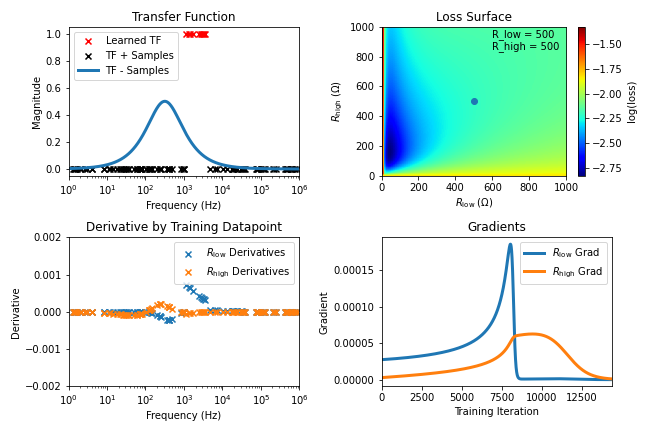

In [21]:
# Plot transfer function over training
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 6))
ws = 2 * math.pi * 10 ** torch.linspace(0, 6, 1000)
subsample = int(dataset_size / 100)
train_data_mask = train_data_band_bin[1][::subsample] > cutoff_mag
ax1.scatter(train_data_band_bin[0][::subsample][train_data_mask] / (2 * math.pi), np.ones(train_data_mask.sum()), c="r", marker="x")
ax1.scatter(train_data_band_bin[0][::subsample][~train_data_mask] / (2 * math.pi), np.zeros((~train_data_mask).sum()), c="k", marker="x")
learned_tf, = ax1.semilogx(ws / (2 * math.pi), evaluate_bp_circuit(ws, *R_values_band_bin[0]), linewidth=3)
ax1.set_xlim([1, 1e6])
ax1.set_title("Transfer Function")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Magnitude")
ax1.legend(["Learned TF", "TF + Samples", "TF - Samples"])

# Show loss surfaces for BCE and MSE Loss
eval_pts = torch.stack(torch.meshgrid((torch.arange(0, 1000, 10), torch.arange(0, 1000, 10)), indexing="ij"))
eval_vals = evaluate_bp_circuit(train_data_band_bin[0][:, None, None], eval_pts[0][None, ...], eval_pts[1][None, ...])
loss_surface = loss_fn(eval_vals, (train_data_band_bin[1][..., None, None].expand(eval_vals.shape) > cutoff_mag).float())
loss_surf = ax2.imshow(torch.log(loss_surface.mean(0)).T, cmap=plt.cm.jet, extent=(0, 1000, 0, 1000), aspect="auto", origin="lower")
cur_loss, = ax2.plot(*R_values_band_bin[0], marker="o")
cur_loss_label = ax2.annotate(f"R_low = {R_values_band_bin[0][0]:.0f}\nR_high = {R_values_band_bin[0][1]:.0f}", (0, 0), xytext=(0.6, 0.85), textcoords='axes fraction')
ax2.set_title("Loss Surface")
ax2.set_xlabel("$R_\mathrm{low} \; (\Omega)$")
ax2.set_ylabel("$R_\mathrm{high} \; (\Omega)$")
fig.colorbar(loss_surf, ax=ax2, label="log(loss)")

# Show loss contributions of each data point
cur_circuit = BandPassCircuit(*R_values_band_bin[0])
data_losses = loss_fn(cur_circuit(train_data_band_bin[0][::subsample]), (train_data_band_bin[1][::subsample] > cutoff_mag).float())
data_grads = torch.zeros((len(data_losses), 2))
for i, dl in enumerate(data_losses):
    data_grads[i] = torch.tensor(torch.autograd.grad(dl, (cur_circuit.R_low, cur_circuit.R_high), retain_graph=True))
data_grads_scat1 = ax3.scatter(train_data_band_bin[0][::subsample] / (2 * math.pi), data_grads[:, 0], marker="x")
data_grads_scat2 = ax3.scatter(train_data_band_bin[0][::subsample] / (2 * math.pi), data_grads[:, 1], marker="x")
ax3.set_xscale("log")
ax3.set_ylabel("Derivative")
ax3.set_xlim([1, 1e6])
ax3.set_ylim([-2e-3, 2e-3])
ax3.set_xlabel("Frequency (Hz)")
ax3.set_title("Derivative by Training Datapoint")
ax3.legend(["$R_\mathrm{low}$ Derivatives", "$R_\mathrm{high}$ Derivatives"])

# Show gradient at each training iteration
ax4.plot(np.arange(len(grad_values_band_bin)), grad_values_band_bin, linewidth=3)
cur_grad0, = ax4.plot(0, grad_values_band_bin[0][0], marker="o")
cur_grad1, = ax4.plot(0, grad_values_band_bin[0][1], marker="o")
ax4.set_xlabel("Training Iteration")
ax4.set_ylabel("Gradient")
ax4.set_title("Gradients")
ax4.set_xlim([-1, len(grad_values_band_bin)])
ax4.legend(["$R_\mathrm{low}$ Grad", "$R_\mathrm{high}$ Grad"])

plt.tight_layout()

# Main update function for interactive plots
def update_iter_band_bin(t=0):
    mags = evaluate_bp_circuit(ws, *R_values_band_bin[t])
    learned_tf.set_data(ws / (2 * math.pi), mags)
    cur_loss.set_data(*R_values_band_bin[t])
    cur_loss_label.set_text(f"R_low = {R_values_band_bin[t][0]:.0f}\nR_high = {R_values_band_bin[t][1]:.0f}")
    cur_grad0.set_data(t, grad_values_band_bin[t][0])
    cur_grad1.set_data(t, grad_values_band_bin[t][1])
    cur_circuit = BandPassCircuit(*R_values_band_bin[t])
    data_losses = loss_fn(cur_circuit(train_data_band_bin[0][::subsample]), (train_data_band_bin[1][::subsample] > cutoff_mag).float())
    data_grads = torch.zeros((len(data_losses), 2))
    for i, dl in enumerate(data_losses):
        data_grads[i] = torch.tensor(torch.autograd.grad(dl, (cur_circuit.R_low, cur_circuit.R_high), retain_graph=True))
    data_grads_scat1.set_offsets(torch.stack((train_data_band_bin[0][::subsample] / (2 * math.pi), data_grads[:, 0])).T)
    data_grads_scat2.set_offsets(torch.stack((train_data_band_bin[0][::subsample] / (2 * math.pi), data_grads[:, 1])).T)
    fig.canvas.draw_idle()
    
# Include sliders for relevant quantities
ip = interactive(update_iter_band_bin, 
                 t=widgets.IntSlider(value=0, min=0, max=len(R_values_band_bin) - 1, step=1, description="Training Iteration", style={'description_width': 'initial'}, layout=Layout(width='100%')))
ip

## (h) Learning a Band Pass Filter Bode Plot from Transfer Function Samples

In [22]:
def evaluate_bp_bode(freqs, low_cutoff, high_cutoff):
    return -20 * nn.ReLU()(torch.log10(freqs / low_cutoff)) + -20 * nn.ReLU()(torch.log10(high_cutoff / freqs))

# PyTorch model of the band pass bode plot
class BandPassBodePlot(nn.Module):
    def __init__(self, low_cutoff=None, high_cutoff=None):
        super().__init__()
        self.low_cutoff = nn.Parameter(torch.rand(1) * 5000 if low_cutoff is None else torch.tensor(float(low_cutoff)))
        self.high_cutoff = nn.Parameter(torch.rand(1) * 5000 if high_cutoff is None else torch.tensor(float(high_cutoff)))
        
    def forward(self, freqs):
        return evaluate_bp_bode(freqs, self.low_cutoff, self.high_cutoff)

# Train a given band pass bode plot
def train_bp_bode(bode, loss_fn, dataset_size, max_training_steps, lr):
    
    cutoff_values = [[float(bode.low_cutoff.data), float(bode.high_cutoff.data)]]
    grad_values = [[np.nan, np.nan]]
    train_data = generate_bp_training_data(dataset_size)
    print(f"Initial Cutoff Values: f_c,l = {float(bode.low_cutoff.data / (2 * math.pi)):.0f} Hz, f_c,h = {float(bode.high_cutoff.data / (2 * math.pi)):.0f} Hz")
    iter_bar = tqdm.trange(max_training_steps, desc="Training Iter")
    for i in iter_bar:
        
        pred = bode(train_data[0])
        loss = loss_fn(pred, 20 * torch.log10(train_data[1])).mean()
        grad = torch.autograd.grad(loss, (bode.low_cutoff, bode.high_cutoff))
        with torch.no_grad():
            bode.low_cutoff -= lr * grad[0]
            bode.high_cutoff -= lr * grad[1]
        
        cutoff_values.append([float(bode.low_cutoff.data), float(bode.high_cutoff.data)])
        grad_values.append([float(grad[0].data), float(grad[1].data)])
        iter_bar.set_postfix_str(f"Loss: {float(loss.data):.3f}, f_c,l = {float(bode.low_cutoff.data / (2 * math.pi)):.0f} Hz, f_c,h = {float(bode.high_cutoff.data / (2 * math.pi)):.0f} Hz")
        if loss.data < 1e-6 or (abs(grad[0].data) < 1e-6 and abs(grad[1].data) < 1e-6):
            break

    print(f"Final Cutoff Values: f_c,l = {float(bode.low_cutoff.data / (2 * math.pi)):.0f} Hz, f_c,h = {float(bode.high_cutoff.data / (2 * math.pi)):.0f} Hz")
    return train_data, cutoff_values, grad_values

In [23]:
bode = BandPassBodePlot()
loss_fn = lambda x, y: (x - y) ** 2    # MSE loss
lr = 1000
train_data_band_bode, cutoffs_band_bode, grad_values_band_bode = train_bp_bode(bode, loss_fn, dataset_size, max_training_steps, lr)

Initial Cutoff Values: f_c,l = 78 Hz, f_c,h = 93 Hz


Training Iter:  65%|██████▍   | 64733/100000 [03:59<02:10, 270.18it/s, Loss: 1.087, f_c,l = 3833 Hz, f_c,h = 1046 Hz]

Final Cutoff Values: f_c,l = 3833 Hz, f_c,h = 1046 Hz


interactive(children=(IntSlider(value=0, description='Training Iteration', layout=Layout(width='100%'), max=64…

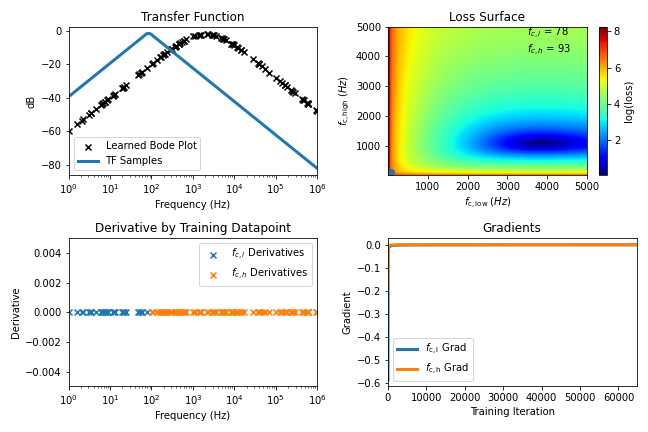

In [24]:
# Plot transfer function over training
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 6))
ws = 2 * math.pi * 10 ** torch.linspace(0, 6, 1000)
subsample = int(dataset_size / 100)
train_data_mask = train_data_band_bode[1][::subsample] > cutoff_mag
ax1.scatter(train_data_band_bode[0][::subsample]/ (2 * math.pi), 20 * torch.log10(train_data_band_bode[1][::subsample]), c="k", marker="x")
learned_tf, = ax1.semilogx(ws / (2 * math.pi), evaluate_bp_bode(ws, *cutoffs_band_bode[0]), linewidth=3)
ax1.set_xlim([1, 1e6])
ax1.set_title("Transfer Function")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("dB")
ax1.legend(["Learned Bode Plot", "TF Samples"])

# Show loss surfaces for BCE and MSE Loss
eval_pts = torch.stack(torch.meshgrid((torch.arange(1, 5001, 50), torch.arange(1, 5001, 50)), indexing="ij"))
eval_vals = evaluate_bp_bode(train_data_band_bode[0][:, None, None], 2 * math.pi * eval_pts[0][None, ...], 2 * math.pi * eval_pts[1][None, ...])
loss_surface = loss_fn(eval_vals, 20 * torch.log10(train_data_band_bode[1])[..., None, None].expand(eval_vals.shape))
loss_surf = ax2.imshow(torch.log(loss_surface.mean(0)).T, cmap=plt.cm.jet, extent=(1, 5000, 1, 5000), aspect="auto", origin="lower")
cur_loss, = ax2.plot(cutoffs_band_bode[0][0] / (2 * math.pi), cutoffs_band_bode[0][1] / (2 * math.pi), marker="o")
cur_loss_label = ax2.annotate(f"$f_{{c,l}}$ = {cutoffs_band_bode[0][0]:.0f}\n$f_{{c,h}}$ = {cutoffs_band_bode[0][1]:.0f}", (0, 0), xytext=(0.7, 0.82), textcoords='axes fraction')
ax2.set_title("Loss Surface")
ax2.set_xlabel("$f_\mathrm{c,low} \; (Hz)$")
ax2.set_ylabel("$f_\mathrm{c,high} \; (Hz)$")
fig.colorbar(loss_surf, ax=ax2, label="log(loss)")

# Show loss contributions of each data point
cur_bode = BandPassBodePlot(*cutoffs_band_bode[0])
data_losses = loss_fn(cur_bode(train_data_band_bode[0][::subsample]), 20 * torch.log10(train_data_band_bode[1][::subsample]))
data_grads = torch.zeros((len(data_losses), 2))
for i, dl in enumerate(data_losses):
    data_grads[i] = torch.tensor(torch.autograd.grad(dl, (cur_bode.low_cutoff, cur_bode.high_cutoff), retain_graph=True))
data_grads_scat1 = ax3.scatter(train_data_band_bode[0][::subsample] / (2 * math.pi), data_grads[:, 0], marker="x")
data_grads_scat2 = ax3.scatter(train_data_band_bode[0][::subsample] / (2 * math.pi), data_grads[:, 1], marker="x")
ax3.set_xscale("log")
ax3.set_ylabel("Derivative")
ax3.set_xlim([1, 1e6])
ax3.set_ylim([-5e-3, 5e-3])
ax3.set_xlabel("Frequency (Hz)")
ax3.set_title("Derivative by Training Datapoint")
ax3.legend(["$f_{c,l}$ Derivatives", "$f_{c,h}$ Derivatives"])

# Show gradient at each training iteration
ax4.plot(np.arange(len(grad_values_band_bode)), grad_values_band_bode, linewidth=3)
cur_grad0, = ax4.plot(0, grad_values_band_bode[0][0], marker="o")
cur_grad1, = ax4.plot(0, grad_values_band_bode[0][1], marker="o")
ax4.set_xlabel("Training Iteration")
ax4.set_ylabel("Gradient")
ax4.set_title("Gradients")
ax4.set_xlim([-1, len(grad_values_band_bode)])
ax4.legend(["$f_\mathrm{c,l}$ Grad", "$f_\mathrm{c,h}$ Grad"])

plt.tight_layout()

# Main update function for interactive plots
def update_iter_band_bode(t=0):
    learned_tf.set_data(ws / (2 * math.pi), evaluate_bp_bode(ws, *cutoffs_band_bode[t]))
    cur_loss.set_data(cutoffs_band_bode[t][0] / (2 * math.pi), cutoffs_band_bode[t][1] / (2 * math.pi))
    cur_loss_label.set_text(f"$f_{{c,l}}$ = {cutoffs_band_bode[t][0] / (2 * math.pi):.0f}\n$f_{{c,h}}$ = {cutoffs_band_bode[t][1] / (2 * math.pi):.0f}")
    cur_grad0.set_data(t, grad_values_band_bode[t][0])
    cur_grad1.set_data(t, grad_values_band_bode[t][1])
    cur_bode = BandPassBodePlot(*cutoffs_band_bode[t])
    data_losses = loss_fn(cur_bode(train_data_band_bode[0][::subsample]), 20 * torch.log10(train_data_band_bode[1][::subsample]))
    data_grads = torch.zeros((len(data_losses), 2))
    for i, dl in enumerate(data_losses):
        data_grads[i] = torch.tensor(torch.autograd.grad(dl, (cur_bode.low_cutoff, cur_bode.high_cutoff), retain_graph=True))
    data_grads_scat1.set_offsets(torch.stack((train_data_band_bode[0][::subsample] / (2 * math.pi), data_grads[:, 0])).T)
    data_grads_scat2.set_offsets(torch.stack((train_data_band_bode[0][::subsample] / (2 * math.pi), data_grads[:, 1])).T)
    fig.canvas.draw_idle()
    
# Include sliders for relevant quantities
ip = interactive(update_iter_band_bode, 
                 t=widgets.IntSlider(value=0, min=0, max=len(cutoffs_band_bode) - 1, step=1, description="Training Iteration", style={'description_width': 'initial'}, layout=Layout(width='100%')))
ip

## (i) Learn a Color Organ Circuit

In [25]:
# PyTorch model of the color organ circuit
class ColorOrganCircuit(nn.Module):
    def __init__(self, R_low=None, R_high=None, R_band_low=None, R_band_high=None):
        super().__init__()
        self.low = LowPassCircuit(R_low)
        self.high = HighPassCircuit(R_high)
        self.band = BandPassCircuit(R_band_low, R_band_high)
        
    def forward(self, freqs):
        return torch.stack((self.low(freqs), self.band(freqs), self.high(freqs)))
    
    
# Generate training data in a uniform log scale of frequences, then evaluate using the true transfer function
R_low_des = 1 / (2 * math.pi * 800 * cap_value)
R_band_low_des = 1 / (2 * math.pi * 4000 * cap_value)
R_band_high_des = 1 / (2 * math.pi * 1000 * cap_value)
R_high_des = 1 / (2 * math.pi * 5000 * cap_value)
def generate_co_training_data(n):
    rand_ws = 2 * math.pi * torch.pow(10, torch.rand(n) * 6)
    labels = torch.stack((evaluate_lp_circuit(rand_ws, R_low_des), evaluate_bp_circuit(rand_ws, R_band_low_des, R_band_high_des), evaluate_hp_circuit(rand_ws, R_high_des)))
    return rand_ws, labels

# Train a given color organ circuit
def train_co_circuit(circuit, loss_fn, dataset_size, max_training_steps, lr):
    
    R_values = [[float(circuit.low.R.data), float(circuit.band.R_low.data), float(circuit.band.R_high.data), float(circuit.high.R.data)]]
    grad_values = [[np.nan, np.nan, np.nan, np.nan]]
    train_data = generate_co_training_data(dataset_size)
    print(f"Initial Resistor Values: LP: {float(circuit.low.R.data):.0f} Ohms, BP (Low): {float(circuit.band.R_low.data):.0f} Ohms, BP (High): {float(circuit.band.R_high.data):.0f} Ohms, HP: {float(circuit.high.R.data):.0f} Ohms")
    
    iter_bar = tqdm.trange(max_training_steps, desc="Training Iter")
    for i in iter_bar:
        pred = circuit(train_data[0])
        loss = loss_fn(pred, (train_data[1] > cutoff_mag).float()).mean()
        grad = torch.autograd.grad(loss, (circuit.low.R, circuit.band.R_low, circuit.band.R_high, circuit.high.R))
        with torch.no_grad():
            circuit.low.R -= lr * grad[0]
            circuit.band.R_low -= lr * grad[1]
            circuit.band.R_high -= lr * grad[2]
            circuit.high.R -= lr * grad[3]
            
        R_values.append([float(circuit.low.R.data), float(circuit.band.R_low.data), float(circuit.band.R_high.data), float(circuit.high.R.data)])
        grad_values.append([float(grad[0].data), float(grad[1].data), float(grad[2].data), float(grad[3].data)])
        iter_bar.set_postfix_str(f"Loss: {float(loss.data):.3f}, Rs = {float(circuit.low.R.data):.0f}, {float(circuit.band.R_low.data):.0f}, {float(circuit.band.R_high.data):.0f}, {float(circuit.high.R.data):.0f}")
        if loss.data < 1e-6 or (abs(grad[0].data) < 1e-6 and abs(grad[1].data) < 1e-6):
            break

    print(f"Final Resistor Values: LP: {float(circuit.low.R.data):.0f} Ohms, BP (Low): {float(circuit.band.R_low.data):.0f} Ohms, BP (High): {float(circuit.band.R_high.data):.0f} Ohms, HP: {float(circuit.high.R.data):.0f} Ohms")
    print(f"Final Cutoff Frequencies: LP: {1 / (2 * math.pi * cap_value * float(circuit.low.R.data)):.0f} Hz, BP (Low): {1 / (2 * math.pi * cap_value * float(circuit.band.R_low.data)):.0f} Hz, BP (High): {1 / (2 * math.pi * cap_value * float(circuit.band.R_high.data)):.0f} Hz, HP: {1 / (2 * math.pi * cap_value * float(circuit.high.R.data)):.0f} Hz")
    return train_data, R_values, grad_values

In [26]:
co = ColorOrganCircuit(200, 200, 200, 200)
loss_fn = lambda x, y: (x - (0.3 + 0.7 * y)) ** 2   # weighted MSE loss
lr = 500
train_data_co, R_values_co, grad_values_co = train_co_circuit(co, loss_fn, dataset_size, max_training_steps, lr)

Initial Resistor Values: LP: 200 Ohms, BP (Low): 200 Ohms, BP (High): 200 Ohms, HP: 200 Ohms


Training Iter:  16%|█▋        | 16458/100000 [01:23<07:03, 197.07it/s, Loss: 0.046, Rs = 230, 36, 188, 32]

Final Resistor Values: LP: 230 Ohms, BP (Low): 36 Ohms, BP (High): 188 Ohms, HP: 32 Ohms
Final Cutoff Frequencies: LP: 691 Hz, BP (Low): 4483 Hz, BP (High): 846 Hz, HP: 4989 Hz


interactive(children=(IntSlider(value=0, description='Training Iteration', layout=Layout(width='100%'), max=16…

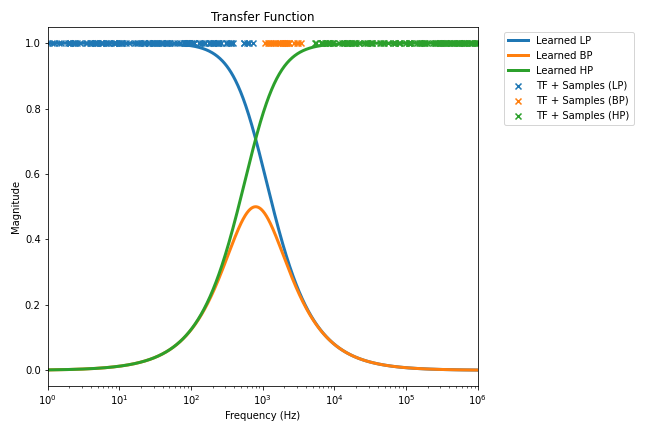

In [27]:
# Plot transfer function over training
fig, ax1 = plt.subplots(1, 1, figsize=(9, 6))
ws = 2 * math.pi * 10 ** torch.linspace(0, 6, 1000)
subsample = int(dataset_size / 250)
train_data_mask = train_data_co[1][:, ::subsample] > cutoff_mag
learned_tf1, = ax1.semilogx(ws / (2 * math.pi), evaluate_lp_circuit(ws, R_values_co[0][0]), linewidth=3)
learned_tf2, = ax1.semilogx(ws / (2 * math.pi), evaluate_bp_circuit(ws, *R_values_co[0][1:3]), linewidth=3)
learned_tf3, = ax1.semilogx(ws / (2 * math.pi), evaluate_hp_circuit(ws, R_values_co[0][-1]), linewidth=3)
ax1.scatter(train_data_co[0][::subsample][train_data_mask[0]] / (2 * math.pi), np.ones(train_data_mask[0].sum()), c=learned_tf1.get_color(), marker="x")
ax1.scatter(train_data_co[0][::subsample][train_data_mask[1]] / (2 * math.pi), np.ones(train_data_mask[1].sum()), c=learned_tf2.get_color(), marker="x")
ax1.scatter(train_data_co[0][::subsample][train_data_mask[2]] / (2 * math.pi), np.ones(train_data_mask[2].sum()), c=learned_tf3.get_color(), marker="x")
# ax1.scatter(train_data_co[0][::subsample][(~train_data_mask).all(0)] / (2 * math.pi), np.zeros((~(train_data_mask.any(0))).sum()), c="k", marker="x")
ax1.set_xlim([1, 1e6])
ax1.set_title("Transfer Function")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Magnitude")
ax1.legend(["Learned LP", "Learned BP", "Learned HP", 
            "TF + Samples (LP)", "TF + Samples (BP)", "TF + Samples (HP)", 
            "TF - Samples"], bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)

plt.tight_layout()

# Main update function for interactive plots
def update_iter_co(t=0):
    learned_tf1.set_data(ws / (2 * math.pi), evaluate_lp_circuit(ws, R_values_co[t][0]))
    learned_tf2.set_data(ws / (2 * math.pi), evaluate_bp_circuit(ws, *R_values_co[t][1:3]))
    learned_tf3.set_data(ws / (2 * math.pi), evaluate_hp_circuit(ws, R_values_co[t][-1]))
    fig.canvas.draw_idle()
    
# Include sliders for relevant quantities
ip = interactive(update_iter_co, 
                 t=widgets.IntSlider(value=0, min=0, max=len(R_values_co) - 1, step=1, description="Training Iteration", style={'description_width': 'initial'}, layout=Layout(width='100%')))
ip

## Visualizing the computation graph for the Color Organ

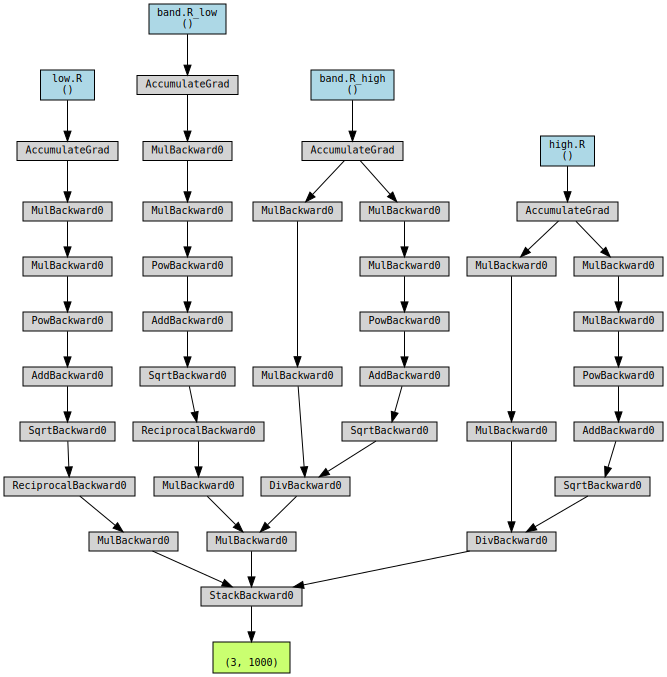

In [28]:
from torchviz import make_dot
make_dot(co(generate_co_training_data(dataset_size)[0]), params=dict(co.named_parameters()))